In [30]:
import numpy as np
import glob
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.model_selection import train_test_split

### Import data set

In [22]:
car = glob.glob('./Data/vehicles/**/*.png')
non_car = glob.glob('./Data/non-vehicles/**/*.png')

print("Number of images with cars: {}").format(len(car))
print("Number of images without cars: {}").format(len(non_car))

car_images = []
noncar_images = []

for car_img in car:
    img = cv2.imread(car_img)
    car_images.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    
for noncar_img in non_car:
    img = cv2.imread(noncar_img)
    noncar_images.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

Number of images with cars: 8792
Number of images without cars: 8968


### Select and display random image from both car and non-car classes

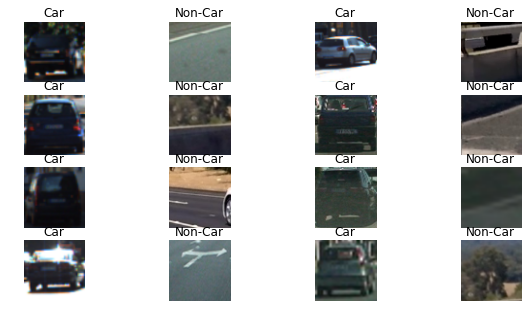

In [23]:
f, axs = plt.subplots(4,4, figsize=(10,5))
axs = axs.ravel()

for i in range(0,16):
    if (i % 2 == 0):
        rand_img = np.random.randint(0,len(car))
        axs[i].imshow(car_images[rand_img])
        axs[i].axis('off')
        axs[i].set_title('Car')
    else:
        rand_img = np.random.randint(0,len(non_car))
        axs[i].imshow(noncar_images[rand_img])
        axs[i].axis('off')
        axs[i].set_title('Non-Car')
plt.savefig('./output_images/car_noncar.png')

### Find HOG features of an example image in each class

(-0.5, 63.5, 63.5, -0.5)

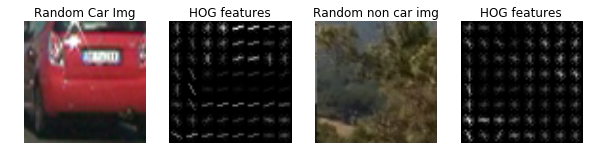

In [40]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
rand_img = np.random.randint(0,len(car))    
rand_car = car_images[rand_img]
hog_features, hog_car = get_hog_features(rand_car[:,:,0], orient=9, 
                        pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

rand_img = np.random.randint(0,len(non_car))    
rand_noncar = noncar_images[rand_img]
hog_features, hog_noncar = get_hog_features(rand_noncar[:,:,0], orient=9, 
                        pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

f, axs = plt.subplots(1,4,figsize=(10,5))
axs = axs.ravel()
axs[0].imshow(rand_car)
axs[0].set_title("Random Car Img")
axs[0].axis('off')
axs[1].imshow(hog_car,cmap='gray')
axs[1].set_title("HOG features")
axs[1].axis('off')
axs[2].imshow(rand_noncar)
axs[2].set_title("Random non car img")
axs[2].axis('off')
axs[3].imshow(hog_noncar,cmap='gray')
axs[3].set_title("HOG features")
axs[3].axis('off')

### Create Targets and split data into train and test data sets

In [41]:
car_targets = np.ones(len(car_images))
noncar_targets = np.zeros(len(noncar_images))


In [44]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
feats = extract_features(car_images)

In [ ]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))